## Analyzing NSL-KDD

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
from tensorflow import keras

%matplotlib inline

2024-11-27 21:41:22.131487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732736482.151201   27534 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732736482.158121   27534 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 21:41:22.180961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Function defines

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def ab_val(val):
    """
    Value for pie chart
    """
    return f"{val:.2f}%"

def piePlot(df, columns_list, rows, columns):
    """
    Create a pie plot
    """
    fig, axes = plt.subplots(rows, columns)
    for ax, col in zip(axes.ravel(), columns_list):
        labels = np.full((1,len(df[col].unique())),'')
        df[col].value_counts().plot(ax=ax,
                                    kind='pie',
                                    autopct=ab_val,
                                    labels=labels[0],
                                    figsize=(25,25),
                                    fontsize=10)
        ax.set_title(col)
        ax.legend(loc=3, labels=df[col].unique())

def printColumns(df, column):
    """
    Print columns to PrettyTable
    """
    values = df[column].unique()
    table = PrettyTable([f"{column} - {df.name}", "Count"])
    for value in values:
        count = df[column].loc[df[column]==value].count()
        table.add_row([f"{value}", f"{count}"])
    print(table)

# 1. Data Exploration

## 1.1. Load data

In [3]:
train = pd.read_csv("data/NSL_KDD/csv/Train20.csv")
train = train.drop(['Unnamed: 0'], axis=1)
train.name = "Train"
test = pd.read_csv("data/NSL_KDD/csv/Test.csv")
test = test.drop(['Unnamed: 0'], axis=1)
test.name = "Test"

In [4]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target,Attack Type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


In [5]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target,Attack Type
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,probe
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,probe


In [6]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

In [7]:
test.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [9]:
train["class"].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy'], dtype=object)

In [10]:
train["target"].unique()

array([20, 15, 19, 21, 18, 17, 16, 12, 14, 11,  2, 13, 10,  9,  8,  7,  3,
        5,  1,  6,  0,  4])

In [11]:
train[["class", "target", "Attack Type"]]

,class,target,Attack Type
0,normal,20,normal
1,normal,15,normal
2,neptune,19,dos
3,normal,21,normal
4,normal,21,normal
...,...,...,...
25187,neptune,19,dos
25188,warezclient,12,r2l
25189,neptune,21,dos
25190,neptune,20,dos


Train data plot

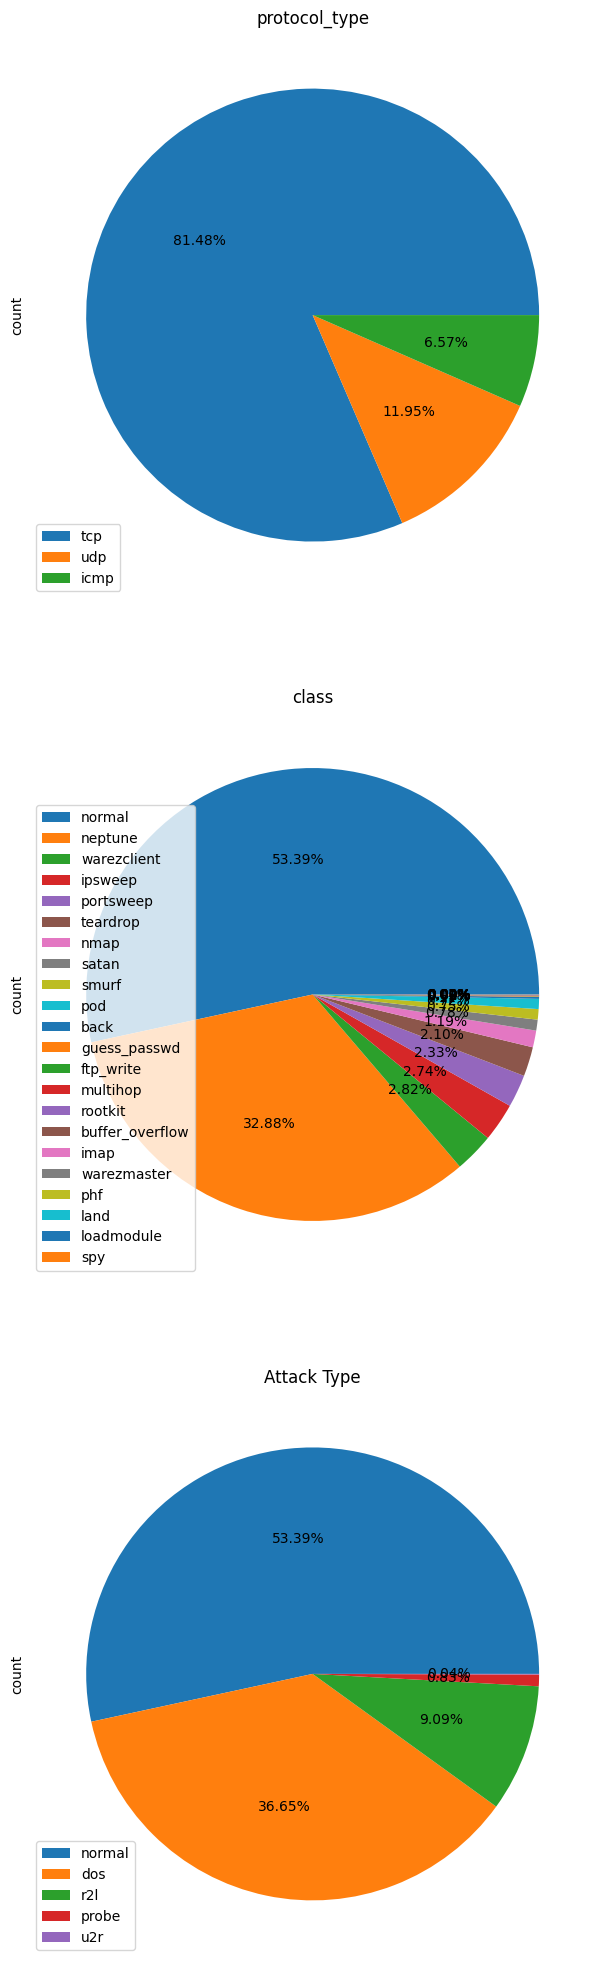

In [12]:
piePlot(train, ["protocol_type", "class", "Attack Type"], 3, 1)

Test data plot

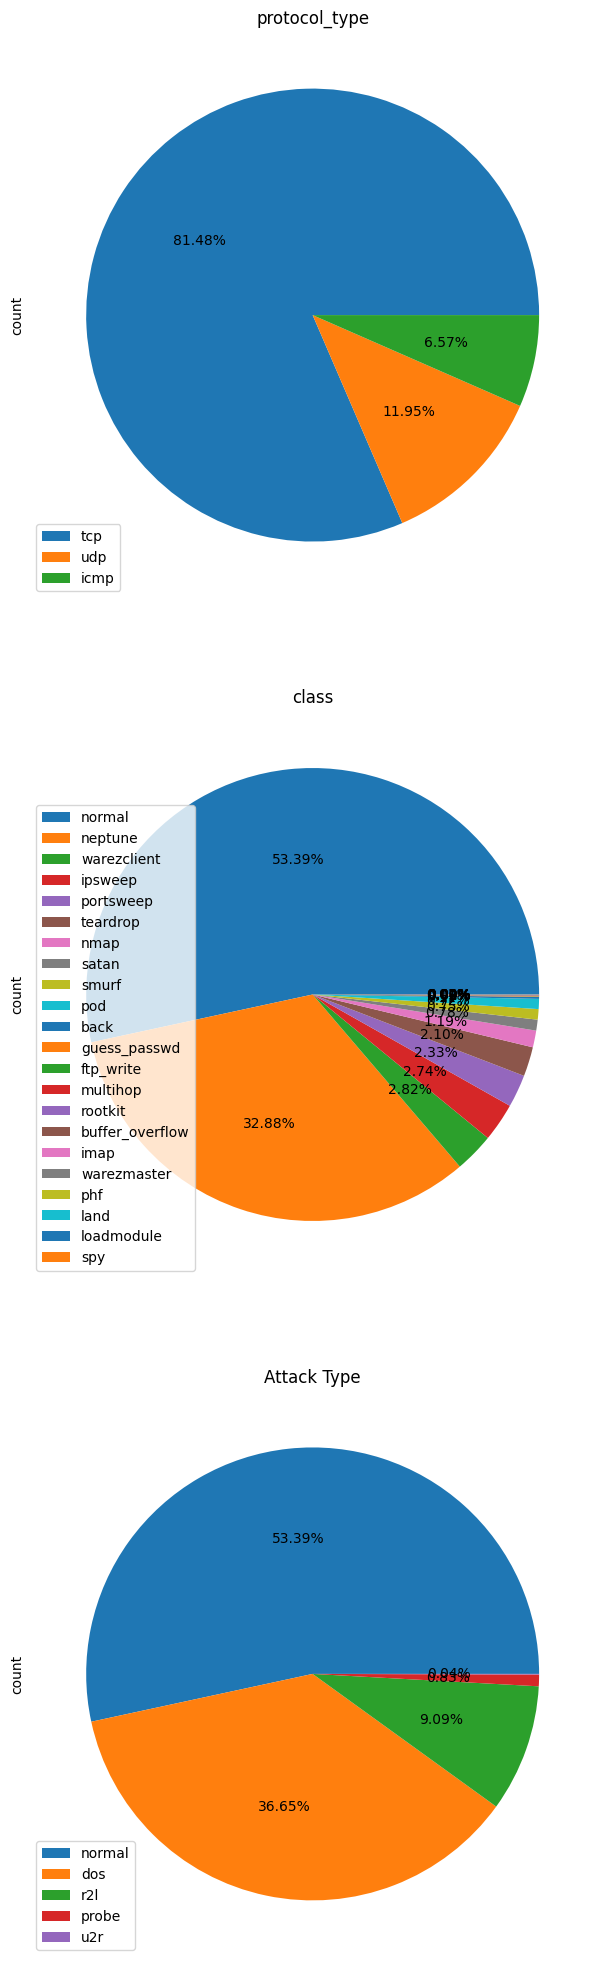

In [13]:
piePlot(train, ["protocol_type", "class", "Attack Type"], 3, 1)

In [14]:
datasets = [train, test]
columns = train.select_dtypes(include='object')

for dataset in datasets:
    for column in columns:
        printColumns(dataset, column)

+-----------------------+-------+
| protocol_type - Train | Count |
+-----------------------+-------+
|          tcp          | 20526 |
|          udp          |  3011 |
|          icmp         |  1655 |
+-----------------------+-------+
+-----------------+-------+
| service - Train | Count |
+-----------------+-------+
|     ftp_data    |  1396 |
|      other      |  858  |
|     private     |  4351 |
|       http      |  8003 |
|    remote_job   |   17  |
|       name      |   92  |
|    netbios_ns   |   76  |
|      eco_i      |  909  |
|       mtp       |   90  |
|      telnet     |  483  |
|      finger     |  366  |
|     domain_u    |  1820 |
|      supdup     |  114  |
|    uucp_path    |  133  |
|      Z39_50     |  172  |
|       smtp      |  1449 |
|     csnet_ns    |  111  |
|       uucp      |  157  |
|   netbios_dgm   |   85  |
|      urp_i      |  124  |
|       auth      |  189  |
|      domain     |  109  |
|       ftp       |  345  |
|       bgp       |  146  |
|     

In [15]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

In [16]:
train["class"]

0             normal
1             normal
2            neptune
3             normal
4             normal
            ...     
25187        neptune
25188    warezclient
25189        neptune
25190        neptune
25191        neptune
Name: class, Length: 25192, dtype: object

In [17]:
test.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

In [18]:
train.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [19]:
test.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

## 2. Data Preprocessing

In [20]:
data = pd.concat([train, test])
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target,Attack Type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21,normal
22540,0,tcp,http,SF,317,938,0,0,0,0,...,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21,normal
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15,dos
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


In [21]:
data = data.drop(["class", "target"], axis=1)
data = data.reset_index()

In [22]:
X = data.drop(["Attack Type"], axis=1)
y = data["Attack Type"]

In [23]:
X.head()

,index,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,tcp,ftp_data,SF,491,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,1,0,udp,other,SF,146,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,2,0,tcp,private,S0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,3,0,tcp,http,SF,232,8153,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,4,0,tcp,http,SF,199,420,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [24]:
le = LabelEncoder()
y = le.fit_transform(y.to_numpy())

In [25]:
def encodeData(df, columns, encoder):
    encoded = encoder.fit_transform(df[columns])
    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns))
    df_encoded = pd.concat([df, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(columns, axis=1)
    return df_encoded

In [26]:
onehotencoder = OneHotEncoder(sparse_output=False)
columns = X.select_dtypes(include='object').columns.tolist()
X = encodeData(X, columns, onehotencoder)

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [28]:
X

array([[-1.72151299, -0.12134467, -0.00968927, ..., -0.07457327,
         0.77414671, -0.04935536],
       [-1.72136917, -0.12134467, -0.00988296, ..., -0.07457327,
         0.77414671, -0.04935536],
       [-1.72122535, -0.12134467, -0.00996493, ..., -0.07457327,
        -1.29174481, -0.04935536],
       ...,
       [ 1.52025005, -0.12134467,  0.02065486, ..., -0.07457327,
         0.77414671, -0.04935536],
       [ 1.52039387, -0.12134467, -0.00994135, ..., -0.07457327,
         0.77414671, -0.04935536],
       [ 1.52053768, -0.12134467, -0.00996493, ..., -0.07457327,
        -1.29174481, -0.04935536]])

In [29]:
y

array([1, 1, 0, ..., 0, 1, 2])

## 3. Creating models

Testing these models:
1. Linear Regression
2. K Nearest Neighbour
3. Random Forest
4. Gradient Boost:
    * XGBoost;
    * CatBoost;
    * LightGBM.
5. Support Vector Machine;
6. Reccurent Neural Networks.

In [30]:
results_dict = {}

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40575, 120), (40575,), (7161, 120), (7161,))

## 3.1. Linear Regression

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [33]:
lin_reg.score(X_test, y_test)

0.7312938738673107

In [34]:
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [35]:
print(f"R2: {lin_reg.score(X_test, y_test)}\n\
MAE: {mae}\n\
MSE: {mse}\n\
RMSE: {rmse}")

R2: 0.7312938738673107
MAE: 0.2548803125129584
MSE: 0.19404900600087002
RMSE: 0.44050993859488574


## 3.2. K Nearest Neighbour

In [36]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

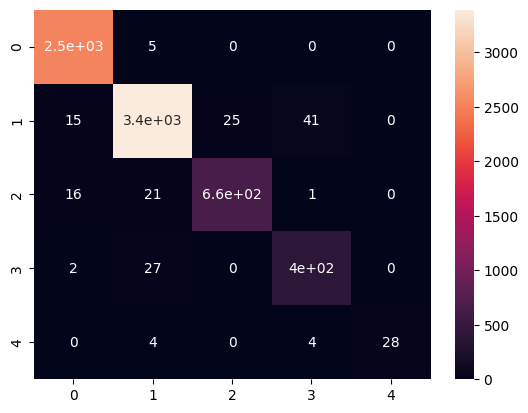

In [37]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [38]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [39]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["KNN"] = results

In [40]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.977517,0.977689,0.977488,0.977517,0.035889,0.064376,0.253725


## 3.3. Random Forest

In [41]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

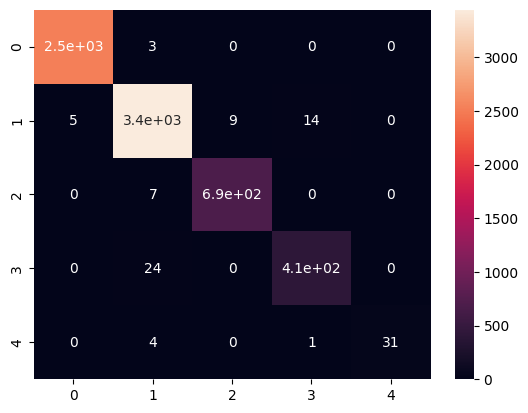

In [42]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [43]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [44]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RF"] = results

In [45]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.977517,0.977689,0.977488,0.977517,0.035889,0.064376,0.253725
RF,0.990644,0.990619,0.990597,0.990644,0.015780,0.029744,0.172466


## 3.4. XGBoost

In [46]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

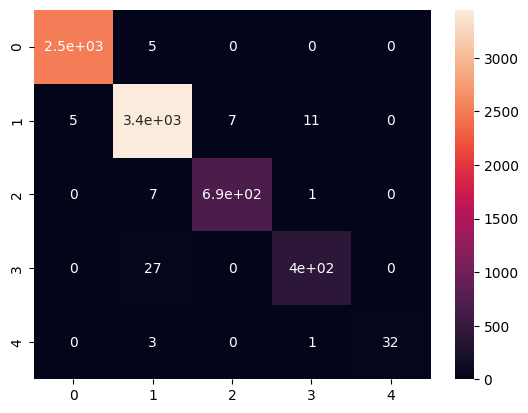

In [47]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [48]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [49]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGBoost"] = results

In [50]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.977517,0.977689,0.977488,0.977517,0.035889,0.064376,0.253725
RF,0.990644,0.990619,0.990597,0.990644,0.015780,0.029744,0.172466
XGBoost,0.990644,0.990613,0.990593,0.990644,0.015501,0.028627,0.169196


## 3.5 LightGBM

In [51]:
lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3527
[LightGBM] [Info] Number of data points in the train set: 40575, number of used features: 107
[LightGBM] [Info] Start training from score -1.052096
[LightGBM] [Info] Start training from score -0.723143
[LightGBM] [Info] Start training from score -2.313862
[LightGBM] [Info] Start training from score -2.774538
[LightGBM] [Info] Start training from score -5.446121


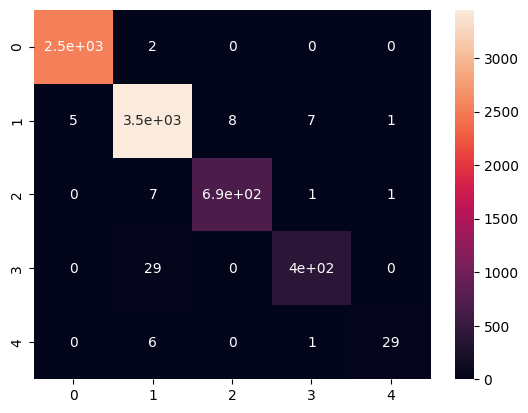

In [52]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [53]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [54]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LightGBM"] = results

In [55]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.977517,0.977689,0.977488,0.977517,0.035889,0.064376,0.253725
RF,0.990644,0.990619,0.990597,0.990644,0.015780,0.029744,0.172466
XGBoost,0.990644,0.990613,0.990593,0.990644,0.015501,0.028627,0.169196
LightGBM,0.990504,0.990438,0.990409,0.990504,0.016618,0.032817,0.181154


## 3.6. Support Vector Machine

In [56]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

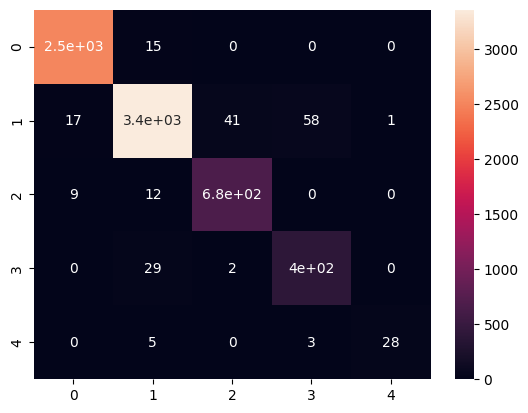

In [57]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [58]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [59]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["SVM"] = results

In [60]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"]).T

,KNN,RF,XGBoost,LightGBM,SVM
Accuracy,0.977517,0.990644,0.990644,0.990504,0.973188
Precision,0.977689,0.990619,0.990613,0.990438,0.973767
F1,0.977488,0.990597,0.990593,0.990409,0.973311
Recall,0.977517,0.990644,0.990644,0.990504,0.973188
MAE,0.035889,0.015780,0.015501,0.016618,0.041894
MSE,0.064376,0.029744,0.028627,0.032817,0.073733
RMSE,0.253725,0.172466,0.169196,0.181154,0.271538


## 3.7. Reccurent Neural Network

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((33271, 120), (33271,), (7304, 120), (7304,), (7161, 120), (7161,))

In [62]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732736527.317944   27534 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4743 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 120)                 │          14,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          61,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,085 (816.74 KB)

 Trainable params: 209,085 (816.74 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
%%time
model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(X_val, y_val))
gc.collect();

Epoch 1/50


I0000 00:00:1732736529.032924   28612 service.cc:148] XLA service 0x761eec004cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732736529.032946   28612 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-11-27 21:42:09.063387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732736529.186548   28612 cuda_dnn.cc:529] Loaded cuDNN version 90501


  81/1040 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7931 - loss: 0.7091

I0000 00:00:1732736530.069857   28612 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9251 - loss: 0.2504 - val_accuracy: 0.9633 - val_loss: 0.0932
Epoch 2/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9728 - loss: 0.0779 - val_accuracy: 0.9722 - val_loss: 0.0756
Epoch 3/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9729 - loss: 0.0690 - val_accuracy: 0.9737 - val_loss: 0.0855
Epoch 4/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9761 - loss: 0.0619 - val_accuracy: 0.9748 - val_loss: 0.0746
Epoch 5/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9768 - loss: 0.0562 - val_accuracy: 0.9749 - val_loss: 0.0732
Epoch 6/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9773 - loss: 0.0579 - val_accuracy: 0.9786 - val_loss: 0.0721
Epoch 7/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9793 - loss: 0.0499 - val_accuracy: 0.9766 - val_loss: 0.0649
Epoch 8/50
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9788 - loss: 0.0517 - val_accurac

In [65]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [74]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0740


In [67]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RNN"] = results

In [72]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

In [73]:
results_df

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.977517,0.977689,0.977488,0.977517,0.035889,0.064376,0.253725
RF,0.990644,0.990619,0.990597,0.990644,0.015780,0.029744,0.172466
XGBoost,0.990644,0.990613,0.990593,0.990644,0.015501,0.028627,0.169196
LightGBM,0.990504,0.990438,0.990409,0.990504,0.016618,0.032817,0.181154
SVM,0.973188,0.973767,0.973311,0.973188,0.041894,0.073733,0.271538
RNN,0.978495,0.978771,0.978597,0.978495,0.035051,0.062701,0.250401


# 4. Plot Results